In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=32)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT= creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC= creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [141]:
loaders_para_concatenar_train = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]

datasets_train = [loader.dataset for loader in loaders_para_concatenar_train]

combined_dataset_train = ConcatDataset(datasets_train)

combined_loader_train = DataLoader(combined_dataset_train, batch_size=32, shuffle=True)

print(f"Total de amostras combinadas: {len(combined_dataset_train)}")
print(f"Total de batches: {len(combined_loader_train)}")

Total de amostras combinadas: 54000
Total de batches: 1688


In [142]:
loaders_para_concatenar_val = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

datasets_val = [loader.dataset for loader in loaders_para_concatenar_val]

combined_dataset_val = ConcatDataset(datasets_val)

combined_loader_val = DataLoader(combined_dataset_val, batch_size=32, shuffle=False)

print(f"Total de amostras combinadas: {len(combined_dataset_val)}")
print(f"Total de batches: {len(combined_loader_val)}")

Total de amostras combinadas: 54000
Total de batches: 1688


In [143]:
loaders_para_concatenar_test = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]

datasets_test = [loader.dataset for loader in loaders_para_concatenar_test]

combined_dataset_test = ConcatDataset(datasets_test)

combined_loader_test = DataLoader(combined_dataset_test, batch_size=32, shuffle=False)

print(f"Total de amostras combinadas: {len(combined_dataset_test)}")
print(f"Total de batches: {len(combined_loader_test)}")

Total de amostras combinadas: 54000
Total de batches: 1688


In [144]:
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [145]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [147]:
def exit_soft_count(logits, thresholds, device, sharpness=50.0):
    probs = F.softmax(logits, dim=1)
    confidence, pred_class = torch.max(probs, dim=1)
    
    if not isinstance(thresholds, torch.Tensor):
        t_tensor = torch.tensor(thresholds, dtype=torch.float32).to(device)
    else:
        t_tensor = thresholds.to(device)
        
    selected_thresholds = t_tensor[pred_class]
    
    soft_decisions = torch.sigmoid(sharpness * (confidence - selected_thresholds))
    
    return soft_decisions.sum()

In [148]:
def train_model(model, train_loader, val_loader, epochs, lr, attack_threshold, normal_threshold, desired_exit_ex1, device, patience=15):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)
    
    model.to(device)
    
    criterion = nn.CrossEntropyLoss() 
    
    metrics = [
        'loss_ex1', 'loss_ex2',
        'total_loss', 'joint_loss', 'ex1_pct', 'ex1_diff'
    ]

    history = {
        'train': {k: [] for k in metrics},
        'val': {k: [] for k in metrics}
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    class_thresholds = [normal_threshold, attack_threshold]

    for epoch in range(epochs):
        model.train()
        
        running_metrics = {k: 0.0 for k in metrics}
        total_steps = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            total_samples = inputs.size(0)
            
            optimizer.zero_grad()
            
            out_1 = model.forward_exit1(inputs)
            loss_1 = criterion(out_1, labels)
            
            out_2 = model.forward_exit2(inputs)
            loss_2 = criterion(out_2, labels)
            
            num_ex1 = exit_soft_count(out_1, class_thresholds, device)
            
            joint_loss = loss_1 * 1 + loss_2 * 1
            
            ex1_percentage = num_ex1 / total_samples
            ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
            
            total_loss = joint_loss + ex1_diff * 1
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_metrics['loss_ex1'] += loss_1.item()
            running_metrics['loss_ex2'] += loss_2.item()
            running_metrics['total_loss'] += total_loss.item()
            running_metrics['joint_loss'] += joint_loss.item()
            running_metrics['ex1_pct'] += ex1_percentage.item()
            running_metrics['ex1_diff'] += ex1_diff.item()
            
            total_steps += 1

        for key in metrics:
            history['train'][key].append(running_metrics[key] / total_steps)
        
        epoch_train_loss = history['train']['total_loss'][-1]
        epoch_train_loss1 = history['train']['loss_ex1'][-1]
        epoch_train_loss2 = history['train']['loss_ex2'][-1]

        model.eval()
        running_metrics_val = {k: 0.0 for k in metrics}
        total_steps_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                total_samples = inputs.size(0)
    
                out_1 = model.forward_exit1(inputs)
                loss_1 = criterion(out_1, labels)
                
                out_2 = model.forward_exit2(inputs)
                loss_2 = criterion(out_2, labels)
    
                num_ex1 = exit_soft_count(out_1, class_thresholds, device)
    
                joint_loss = loss_1 * 1 + loss_2 * 1
                ex1_percentage = num_ex1 / total_samples
                ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
                total_loss = joint_loss + ex1_diff * 1
                                                                                            
                running_metrics_val['loss_ex1'] += loss_1.item()
                running_metrics_val['loss_ex2'] += loss_2.item()
                running_metrics_val['total_loss'] += total_loss.item()
                running_metrics_val['joint_loss'] += joint_loss.item()
                running_metrics_val['ex1_pct'] += ex1_percentage.item()
                running_metrics_val['ex1_diff'] += ex1_diff.item()
                
                total_steps_val += 1

        for key in metrics:
            history['val'][key].append(running_metrics_val[key] / total_steps_val)

        epoch_val_loss = history['val']['total_loss'][-1]
        epoch_val_loss1 = history['val']['loss_ex1'][-1]
        epoch_val_loss2 = history['val']['loss_ex2'][-1]
        
        print(f'Epoch [{epoch+1}/{epochs}] | Train Total Loss: {epoch_train_loss:.4f} | Val Total Loss: {epoch_val_loss:.4f}\nTrain Loss Exit 1: {epoch_train_loss1:.4f} | Train Loss Exit 2: {epoch_train_loss2:.4f}\nVal Loss Exit 1: {epoch_val_loss1:.4f} | Val Loss Exit 2: {epoch_val_loss2:.4f}\n\n')        
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping...")
                if best_model_state: model.load_state_dict(best_model_state)
                break
                
        scheduler.step(epoch_val_loss)
                
    epochs_range = range(1, len(history['train']['total_loss']) + 1)
    
    fig, axs = plt.subplots(1, 5, figsize=(45, 7))
    
    ax = axs[0]
    ax.set_title("Exit 1")
    ax.plot(epochs_range, history['train']['loss_ex1'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss_ex1'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.set_title("Exit 2")
    ax.plot(epochs_range, history['train']['loss_ex2'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss_ex2'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    ax.set_title("Global Optimization")
    ax.plot(epochs_range, history['train']['total_loss'], label='Tr Total', color='orange')
    ax.plot(epochs_range, history['val']['total_loss'], label='Val Total', color='orange', linestyle='--')
    ax.plot(epochs_range, history['train']['joint_loss'], label='Tr Joint', color='blue', alpha=0.7)
    ax.plot(epochs_range, history['val']['joint_loss'], label='Val Joint', color='blue', linestyle='--', alpha=0.7)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[3]
    ax.set_title("Exit 1 Rate (Percentage)")
    ax.plot(epochs_range, history['train']['ex1_pct'], label='Tr Rate', color='green')
    ax.plot(epochs_range, history['val']['ex1_pct'], label='Val Rate', color='green', linestyle='--')
    ax.axhline(y=desired_exit_ex1, color='red', linestyle=':', label='Desired')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Ratio (0-1)')
    ax.legend()
    ax.grid(True)

    ax = axs[4]
    ax.set_title("Exit 1 Rate Error (|Desired - Actual|)")
    ax.plot(epochs_range, history['train']['ex1_diff'], label='Tr Diff', color='purple')
    ax.plot(epochs_range, history['val']['ex1_diff'], label='Val Diff', color='purple', linestyle='--')
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    return history

In [149]:
def precompute_outputs(model, loader, device):
    model.to(device)
    model.eval()

    all_probs_exit1 = []
    all_probs_exit2 = []
    all_labels = []
    
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            
            output1 = model.forward_exit1(samples)
            probs1 = F.softmax(output1, dim=1)
            
            output2 = model.forward_exit2(samples)
            probs2 = F.softmax(output2, dim=1)

            all_probs_exit1.append(probs1.cpu())
            all_probs_exit2.append(probs2.cpu())
            all_labels.append(labels.cpu())

    probs_exit1 = torch.cat(all_probs_exit1)
    probs_exit2 = torch.cat(all_probs_exit2)
    targets = torch.cat(all_labels)
    
    return probs_exit1, probs_exit2, targets

In [150]:
def compute_decisions(preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2):
    thresh_tensor1 = torch.where(preds1 == 1, t_atk1, t_norm1)
    mask_exit1 = confs1 > thresh_tensor1
    
    thresh_tensor2 = torch.where(preds2 == 1, t_atk2, t_norm2)
    mask_exit2 = (~mask_exit1) & (confs2 > thresh_tensor2)
    
    mask_rejected = (~mask_exit1) & (~mask_exit2)
    
    return mask_exit1, mask_exit2, mask_rejected

In [151]:
def calculate_metrics(targets, preds1, preds2, mask_exit1, mask_rejected):
    total_samples = len(targets)
    
    final_preds = preds2.clone()
    final_preds[mask_exit1] = preds1[mask_exit1]
    
    mask_accepted = ~mask_rejected
    
    if mask_accepted.sum() == 0:
        return 1.0, 0.0, 0.0, 0.0
        
    y_true_accepted = targets[mask_accepted]
    y_pred_accepted = final_preds[mask_accepted]

    cm = confusion_matrix(y_true_accepted, y_pred_accepted)
    
    f1 = f1_score(y_true_accepted.numpy(), y_pred_accepted.numpy(), zero_division=0)
    error_rate = 1 - f1
    
    rate_exit1 = mask_exit1.sum().item() / total_samples
    rate_rejection = mask_rejected.sum().item() / total_samples
    
    return error_rate, f1, rate_exit1, rate_rejection, cm

In [152]:
def grid_search_rejection(probs1, probs2, targets, max_reject_rate=0.1):
    threshold_values = [round(x * 0.05, 2) for x in range(10, 21)]
    
    confs1, preds1 = torch.max(probs1, dim=1)
    confs2, preds2 = torch.max(probs2, dim=1)
    
    results = {'rejection': [], 'error': [], 'exit1_rate': []}
    
    best_config = {
        'error': float('inf'),
        'params': None,
        'metrics': {}
    }
    
    print(f"Iniciando Grid Search ({len(threshold_values)**4} combinações)...")
    
    for t_atk1, t_norm1, t_atk2, t_norm2 in itertools.product(threshold_values, repeat=4):
        
        mask_exit1, mask_exit2, mask_rejected = compute_decisions(
            preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2
        )
        
        cnt_rejected = mask_rejected.sum().item()
        rate_rejection_pct = (cnt_rejected / len(targets))
        
        if rate_rejection_pct > max_reject_rate:
            continue
            
        error, f1, rate_ex1, rate_rej, cm = calculate_metrics(
            targets, preds1, preds2, mask_exit1, mask_rejected
        )
        
        results['rejection'].append(rate_rej)
        results['error'].append(error)
        results['exit1_rate'].append(rate_ex1)
        
        if error < best_config['error']:
            best_config['error'] = error
            best_config['params'] = (t_atk1, t_norm1, t_atk2, t_norm2)
            best_config['metrics'] = {
                'F1': f1,
                'Rejection': rate_rej,
                'Exit1': rate_ex1,
                'Confusion Matrix': cm
            }

    return results, best_config

In [153]:
def apply_thresholds_to_dataset(model, loader, device, params):
    t_atk1, t_norm1, t_atk2, t_norm2 = params
    
    probs1, probs2, targets = precompute_outputs(model, loader, device)
    confs1, preds1 = torch.max(probs1, dim=1)
    confs2, preds2 = torch.max(probs2, dim=1)
    
    mask_exit1, mask_exit2, mask_rejected = compute_decisions(
        preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2
    )
    
    error, f1, rate_ex1, rate_rej, cm = calculate_metrics(
        targets, preds1, preds2, mask_exit1, mask_rejected
    )
    
    return {
        'F1 Score': f1,
        'Error Rate': error,
        'Exit 1 Ratio': rate_ex1,
        'Rejection Ratio': rate_rej,
        'Confusion Matrix': cm
    }

In [154]:
def run_global_evaluation(model, combined_loader, individual_loaders_dict, device):
    model.to(device)
    model.eval()
    
    probs_comb_1, probs_comb_2, targets_comb = precompute_outputs(model, combined_loader, device)
    
    start_time = time.time()
    gs_history, best_config = grid_search_rejection(probs_comb_1, probs_comb_2, targets_comb)
    print(f"Grid Search concluído em {time.time() - start_time:.2f}s")
    
    best_params = best_config['params']
    print(f"\nMelhores Parâmetros (Concatenado): {best_params}")
    
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(gs_history['rejection'], gs_history['error'], 
                     c=gs_history['exit1_rate'], cmap='viridis', s=15, alpha=0.6)
    plt.colorbar(sc, label='Taxa Saída 1')
    plt.xlabel('Taxa de Rejeição')
    plt.ylabel('Erro (1 - F1)')
    plt.show()
    
    
    results_list = []
    
    results_list.append({
        'Dataset': 'COMBINED (Global)',
        'F1 Score': best_config['metrics']['F1'],
        'Rejection': best_config['metrics']['Rejection'],
        'Exit 1': best_config['metrics']['Exit1'],
        'Confusion Matrix': best_config['metrics']['Confusion Matrix']
        
    })
    
    for name, loader in individual_loaders_dict.items():
        print(f"Processando {name}...")
        res = apply_thresholds_to_dataset(model, loader, device, best_params)
        
        results_list.append({
            'Dataset': name,
            'F1 Score': res['F1 Score'],
            'Rejection': res['Rejection Ratio'],
            'Exit 1': res['Exit 1 Ratio'],
            'Confusion Matrix': res['Confusion Matrix']
        })
    
    df_results = pd.DataFrame(results_list)
    display(df_results)
    
    return df_results, best_params

In [155]:
modelname = 'final_0.1'
modelname

'final_0.1'

Epoch [1/500] | Train Total Loss: 1.3399 | Val Total Loss: 1.1692
Train Loss Exit 1: 0.6604 | Train Loss Exit 2: 0.5826
Val Loss Exit 1: 0.6159 | Val Loss Exit 2: 0.4887


Epoch [2/500] | Train Total Loss: 1.1133 | Val Total Loss: 1.0448
Train Loss Exit 1: 0.5735 | Train Loss Exit 2: 0.4965
Val Loss Exit 1: 0.5354 | Val Loss Exit 2: 0.4643


Epoch [3/500] | Train Total Loss: 1.0295 | Val Total Loss: 0.9731
Train Loss Exit 1: 0.5257 | Train Loss Exit 2: 0.4635
Val Loss Exit 1: 0.5034 | Val Loss Exit 2: 0.4236


Epoch [4/500] | Train Total Loss: 0.9833 | Val Total Loss: 0.9293
Train Loss Exit 1: 0.5061 | Train Loss Exit 2: 0.4355
Val Loss Exit 1: 0.4902 | Val Loss Exit 2: 0.3970


Epoch [5/500] | Train Total Loss: 0.9413 | Val Total Loss: 0.8682
Train Loss Exit 1: 0.4953 | Train Loss Exit 2: 0.4080
Val Loss Exit 1: 0.4802 | Val Loss Exit 2: 0.3499


Epoch [6/500] | Train Total Loss: 0.9061 | Val Total Loss: 0.8268
Train Loss Exit 1: 0.4859 | Train Loss Exit 2: 0.3820
Val Loss Exit 1: 0.4

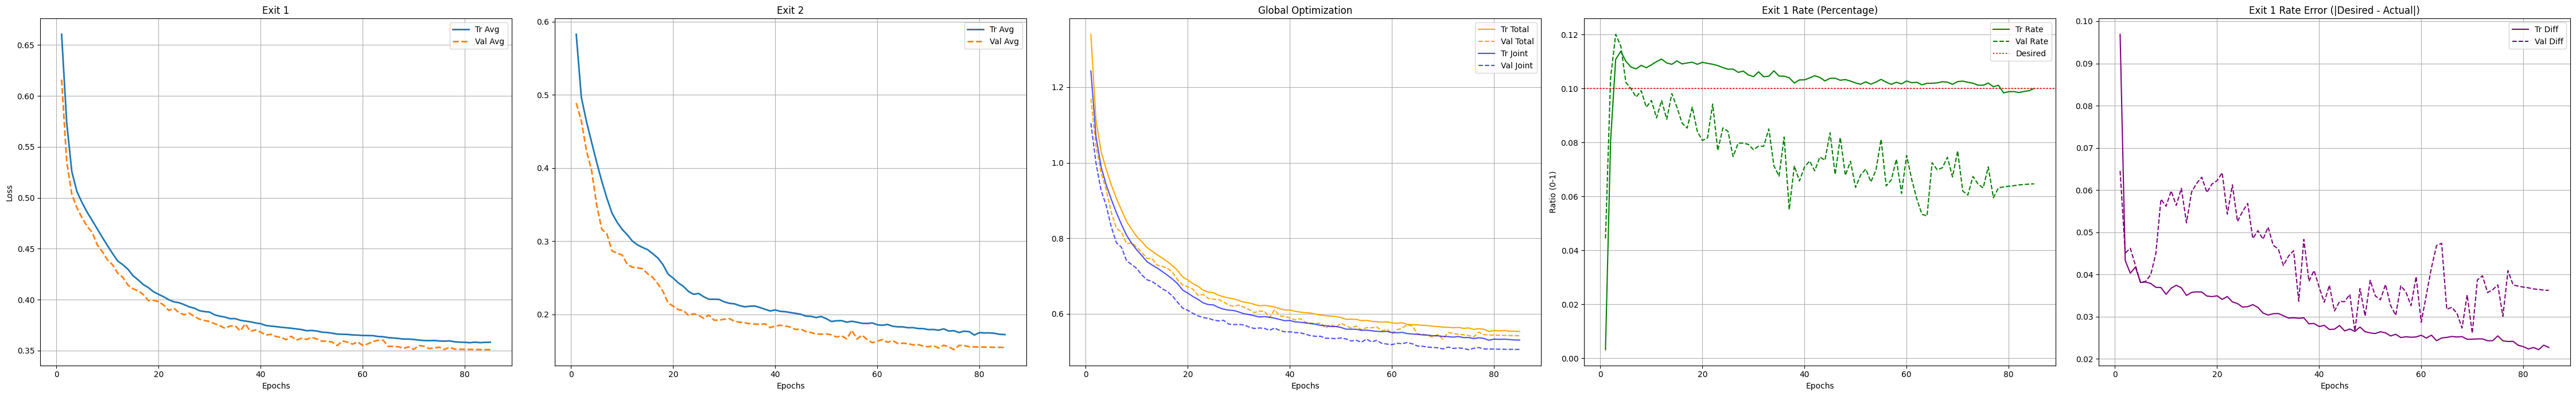


Modelo treinado e salvo em 'models/final_0.1.pth'
Curvas de aprendizado salvas em 'logs/final_0.1_history.csv'


In [156]:
epochs = 500

history = train_model(
    model=model, 
    train_loader=combined_loader_train, 
    val_loader=combined_loader_val, 
    epochs=epochs, 
    lr=0.0001, 
    attack_threshold=0.85, 
    normal_threshold=0.85, 
    desired_exit_ex1=0.1, 
    device=device
)

torch.save(model.state_dict(), f'models/{modelname}.pth')
print(f"\nModelo treinado e salvo em 'models/{modelname}.pth'")

df_train = pd.DataFrame(history['train'])
df_val = pd.DataFrame(history['val'])

df_train = df_train.add_prefix('train_')
df_val = df_val.add_prefix('val_')

df_history = pd.concat([df_train, df_val], axis=1)

df_history.insert(0, 'epoch', range(1, len(df_history) + 1))

csv_filename = f'logs/{modelname}_history.csv'
df_history.to_csv(csv_filename, index=False)
print(f"Curvas de aprendizado salvas em '{csv_filename}'")

In [157]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/{modelname}.pth")

metrics_unsw = apply_thresholds_to_dataset(model, test_loader_UNSW, device, [0.85, 0.85, 0.85, 0.85])

print(f'F1 = {metrics_unsw['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_unsw['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_unsw['Rejection Ratio']:.4}')
print(f'Confusion Matrix:\n{metrics_unsw['Confusion Matrix']}')

Model from: models/final_0.1.pth
F1 = 0.991
Exit 1 Ratio = 0.007333
Rejection Ratio = 0.07528
Confusion Matrix:
[[8283  100]
 [  49 8213]]


In [158]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/{modelname}.pth")

metrics_bot = apply_thresholds_to_dataset(model, test_loader_BOT, device, [0.85, 0.85, 0.85, 0.85])

print(f'F1 = {metrics_bot['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_bot['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_bot['Rejection Ratio']:.4}')
print(f'Confusion Matrix:\n{metrics_bot['Confusion Matrix']}')

Model from: models/final_0.1.pth
F1 = 0.9242
Exit 1 Ratio = 0.01238
Rejection Ratio = 0.1775
Confusion Matrix:
[[3451   13]
 [ 428 2688]]


In [159]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/{modelname}.pth")

metrics_cic = apply_thresholds_to_dataset(model, test_loader_CIC, device, [0.85, 0.85, 0.85, 0.85])

print(f'F1 = {metrics_cic['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_cic['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_cic['Rejection Ratio']:.4}')
print(f'Confusion Matrix:\n{metrics_cic['Confusion Matrix']}')

Model from: models/final_0.1.pth
F1 = 0.9657
Exit 1 Ratio = 0.001857
Rejection Ratio = 0.06614
Confusion Matrix:
[[12672   116]
 [  777 12583]]


In [160]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/{modelname}.pth")

metrics_combined = apply_thresholds_to_dataset(model, combined_loader, device, [0.85, 0.85, 0.85, 0.85])

print(f'F1 = {metrics_combined['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_combined['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_combined['Rejection Ratio']:.4}')
print(f'Confusion Matrix:\n{metrics_combined['Confusion Matrix']}')

Model from: models/final_0.1.pth
F1 = 0.9702
Exit 1 Ratio = 0.004
Rejection Ratio = 0.08224
Confusion Matrix:
[[24391   244]
 [ 1212 23712]]


Iniciando Grid Search (14641 combinações)...
Grid Search concluído em 220.02s

Melhores Parâmetros (Concatenado): (0.85, 0.7, 0.8, 0.95)


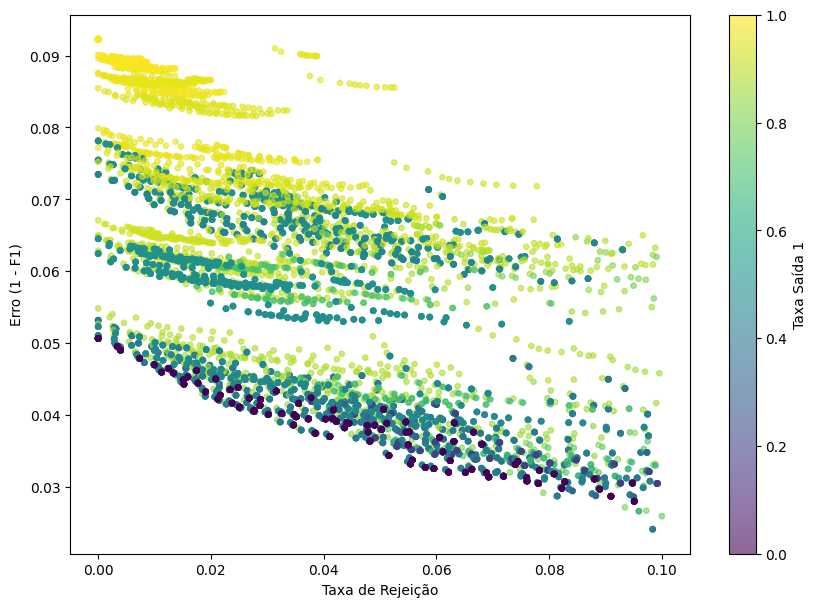

Processando UNSW...
Processando BoT-IoT...
Processando CIC-IDS...


,Dataset,F1 Score,Rejection,Exit 1,Confusion Matrix
0,COMBINED (Global),0.975920,0.098370,0.405852,"[[23618, 289], [890, 23891]]"
1,UNSW,0.991658,0.082222,0.401722,"[[7998, 113], [28, 8381]]"
2,BoT-IoT,0.968716,0.229000,0.427000,"[[3300, 17], [157, 2694]]"
3,CIC-IDS,0.966655,0.077893,0.407714,"[[12354, 135], [734, 12596]]"


In [161]:
loaders_individuais = {
    'UNSW': test_loader_UNSW,
    'BoT-IoT': test_loader_BOT,
    'CIC-IDS': test_loader_CIC
}

df_final, best_thresholds = run_global_evaluation(model, combined_loader, loaders_individuais, device)